In [218]:
%matplotlib inline
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from IPython.display import display

import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import itertools

import MESS
from MESS.util import set_params

## Set some pandas options to show the full rows and columns of a DF
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## Where do you want the simulation output to life?
analysis_dir = "/home/isaac/Continuosity/MESS/analysis/"
analysis_dir = analysis_dir + "/parameter-estimation-cv/"
if not os.path.exists(analysis_dir):
    os.mkdir(analysis_dir)

## First a toy example implementing the RF Regression class

[0.00446853 0.99553147 0.         0.        ]
[[-14.56605054 -15.80068559]]


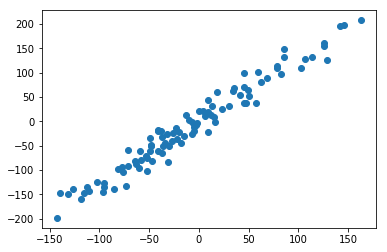

In [2]:
## This is a toy example that uses simulated correlated features
X, y = make_regression(n_samples=100, n_targets=2, n_features=4, n_informative=2,
                        random_state=0, shuffle=False, noise=10)
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
regr.fit(X, y)
print(regr.feature_importances_)
print(regr.predict([[0, 0, 0, 0]]))
plt.scatter(y[:,0], y[:,1])

## Run a baby-sim to be sure MESS is working

In [192]:
r = MESS.Region("r1")
r.paramsdict["generations"] = 0
r.set_param("project_dir", analysis_dir)
r.set_param("m", (0.001, 0.01))
r.set_param("J", (500, 10000))
r.islands["Loc1"].paramsdict
#r.run(sims=1)


  Project directory exists. Additional simulations will be appended.


OrderedDict([('name', 'Loc1'),
             ('J', 3806),
             ('m', 0.0030560719034298514),
             ('speciation_rate', 0),
             ('background_death', 0.25)])

## Generate a bunch of simulations for ranges of some parameters of interest

If you haven't already done so you should fire up an ipcluster instance on your HPC/workstation. SSH to the computer that is running this notebook and do this:

`ipcluster start -n 40 --cluster-id="MESS-Rich" --daemonize`

Later you can stop this ipcluster with this command:

`ipcluster stop --cluster-id="MESS-Rich"`

Now create an client interface to the cluster (which we'll call ipyclient). You can see how many nodes we have access to by asking for the length if the ipyclient object.

In [13]:
ipyclient = ipp.Client(cluster_id="MESS-Rich")
print(len(ipyclient))

40


In [217]:
r = MESS.Region("r1")
r._log_files = True
r.set_param("generations", 0.5)
r.set_param("m", (0.001, 0.05))
r.set_param("speciation_rate", (0.0001, 0.001))
r.set_param("project_dir", analysis_dir)
r.set_param("J", (500, 10000))
r.run(sims=1000, ipyclient=ipyclient)

  Project directory exists. Additional simulations will be appended.
    Generating 1000 simulation(s).
  [###############     ]  77%  Performing Simulations    | 1:12:38 | 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  [#################   ]  86%  Performing Simulations    | 1:21:43 | 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  [################### ]  97%  Performing Simulations    | 1:30:35 | 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  [################### ]  99%  Performing Simulations    | 1:39:10 | 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  [################### ]  99%  Performing Simulations    | 1:47:45 | 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  [################### ]  99%  Performing Simulations    | 1:55:51 | 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Lets take a look at the first 5 results
Now that the simulations are complete lets take a peek at the results.

In [209]:
SIMOUT = "{}/SIMOUT.txt".format(analysis_dir)
sim_df = pd.read_csv(SIMOUT, sep="\t", header=0)
print("Nsims", len(sim_df))

('Nsims', 2018)


## Clean the data, divide features and targets, and split training and test sets

In [210]:
## Get rid of failed simulations
sim_df = sim_df.dropna()

## Select features. The first line here takes all abundance and pi hill numbers.
## The second line just takes hill 1 for abundance and pi
## The third line uses all of the sumstats
#features = [x for x in sim_df.columns if "_h" in x]
#features = ["abund_h1", "pi_h1"]
features = sim_df.iloc[:, 22:43].columns

## Parameters to estimate
targets = ["J", "speciation_rate", "m"]

X = sim_df[features]
y = sim_df[targets]

## Split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)


## Search parameter space for the best params given the data

In [211]:
## Set search ranges for all parameter values of interest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

## Randomly search 100 different parameter combinations and take the
## one that reduces CV error
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(),\
                               param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=0, n_jobs = -1)
rf_random.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

## what are the best parameters?

In [212]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1000}

## Feature importances and model performance
The R2 here is really bad because speciation rate is hard to estimate.
R2 scores for J and m are quite good. Species richness soaks up most of the 
feature importance, though so maybe it's an artifact for now.

In [213]:
model = rf_random.best_estimator_
ypred = model.predict(Xtest)

print(model.feature_importances_)
print(metrics.explained_variance_score(ypred, ytest))
print(metrics.r2_score(ypred, ytest))  

[0.67037157 0.03174772 0.00803484 0.01106243 0.01703773 0.01319224
 0.00734701 0.00579792 0.00696186 0.01837299 0.01328927 0.006608
 0.00857947 0.00169399 0.00680843 0.01964178 0.01165979 0.013948
 0.01816128 0.09580675 0.01387692]
-0.5832846483081361
-0.591464282701672


## Cross-Validation scores

In [214]:
scores = cross_val_score(model, X, y, cv=5, n_jobs=-1)
scores

array([0.74385796, 0.78934961, 0.71368041, 0.75296035, 0.79710002])

## CV predictions!
This is essentially the same to the good old ABC leave-one-out cross validation. `cross_val_predict` does the CV for the given k-folds and returns not the cv score,
but the predicted value of each target when it was in the holdout set. FUck!

In [220]:
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1)
cv_preds[:2]

array([[1.58394218e+03, 4.34889000e-04, 1.94062076e-02],
       [1.57098522e+03, 4.11938693e-04, 1.76391871e-02]])

0.7602582286003994
0.7602581993382237
0.2583793174635568
0.25833178894110753
0.7123621303004228
0.7122690594535066


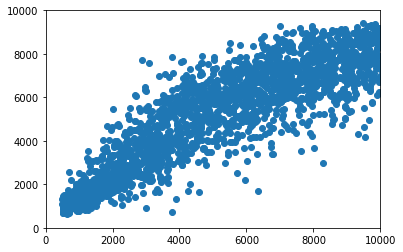

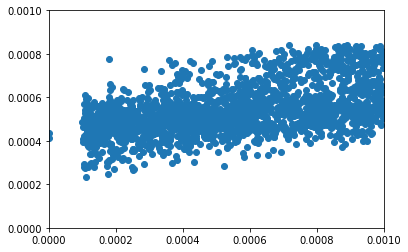

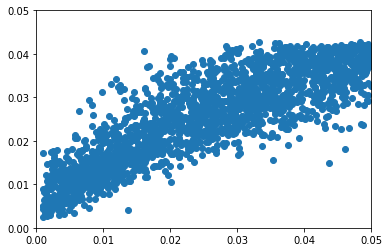

In [231]:
for i, p, lims in zip([0, 1, 2], ["J", "speciation_rate", "m"],
                         [(0, 10000), (0, 0.001), (0, 0.05)]):
    fig, ax = plt.subplots()
    print(metrics.explained_variance_score(y.iloc[:, i], cv_preds[:, i]))
    print(metrics.r2_score(y.iloc[:, i], cv_preds[:, i])) 
    ax.scatter(y.iloc[:, i], cv_preds[:, i])
    ax.set_xlim(lims)
    ax.set_ylim(lims)

# Bolierplate below here (copied from a different NB)

## Helper functions related to real data

In [4]:
## Helper function for getting an obs SGD as a list
def obs_sgd_to_np(infile, normed=True):
    with open(infile) as indat:
        dat = indat.readlines()[1]
        dat = np.array([int(x.strip()) for x in dat.split() if x != " "])
    if normed:
        dat = dat/float(dat.sum())
    return dat
obs_sgd_to_np("/home/isaac/SGD_empirical/empirical_snails/snail.obs")

array([0.26086957, 0.2173913 , 0.2173913 , 0.13043478, 0.06521739,
       0.06521739, 0.        , 0.02173913, 0.        , 0.02173913])

In [5]:
obs_files = {"snails":"/home/isaac/SGD_empirical/empirical_snails/snail.obs",
          "moths":"/home/isaac/SGD_empirical/empirical_micromoths/micromoth.obs",
          "spider":"/home/isaac/SGD_empirical/empirical_reunion_spiders/spider.obs",
          "reunion_weevil":"/home/isaac/SGD_empirical/empirical_weevils/reunion.obs",
          "mauritius_weevil":"/home/isaac/SGD_empirical/empirical_weevils/mauritius.obs"}
obs_dat = {obs:obs_sgd_to_np(f) for obs, f in obs_files.items()}
print(obs_dat)

{'snails': array([0.26086957, 0.2173913 , 0.2173913 , 0.13043478, 0.06521739,
       0.06521739, 0.        , 0.02173913, 0.        , 0.02173913]), 'moths': array([0.57843137, 0.14705882, 0.1372549 , 0.02941176, 0.04901961,
       0.00980392, 0.01960784, 0.00980392, 0.00980392, 0.00980392]), 'spider': array([0.14035088, 0.43859649, 0.12280702, 0.07017544, 0.01754386,
       0.05263158, 0.03508772, 0.07017544, 0.01754386, 0.03508772]), 'reunion_weevil': array([0.11111111, 0.14814815, 0.18518519, 0.14814815, 0.07407407,
       0.14814815, 0.07407407, 0.        , 0.        , 0.11111111]), 'mauritius_weevil': array([0.15384615, 0.23076923, 0.07692308, 0.34615385, 0.03846154,
       0.03846154, 0.03846154, 0.        , 0.03846154, 0.03846154])}


In [6]:
import glob
aquatic_files = glob.glob("/home/isaac/SGD_empirical/empirical_aquatic_metagenome/aquatic_metagenome_obs/*.obs")
#aquatic_files[0].rsplit("/", 1)
aquatic_dat = {f.rsplit("/", 1)[1]:obs_sgd_to_np(f) for f in aquatic_files}
aquatic_dat

{'II-2008_1.obs': array([0.5333927 , 0.02404274, 0.08726625, 0.18967053, 0.11843277,
        0.03116652, 0.01068566, 0.00178094, 0.00178094, 0.00178094]),
 'III-2008_7.obs': array([0.43767573, 0.08059981, 0.27460169, 0.17994377, 0.01968135,
        0.00656045, 0.        , 0.        , 0.        , 0.00093721]),
 'I-2013_1.obs': array([0.63530778, 0.05691057, 0.06620209, 0.12311266, 0.07200929,
        0.03135889, 0.00813008, 0.00232288, 0.00232288, 0.00232288]),
 'III-2011_4.obs': array([6.34328358e-01, 2.55302435e-02, 1.12333071e-01, 1.79890024e-01,
        3.65278869e-02, 7.85545954e-03, 1.57109191e-03, 7.85545954e-04,
        7.85545954e-04, 3.92772977e-04]),
 'V-2011_1.obs': array([0.4212283 , 0.01869159, 0.08477971, 0.13284379, 0.19158879,
        0.10480641, 0.03404539, 0.00734312, 0.00267023, 0.00200267]),
 'IV-2012_4.obs': array([0.54561404, 0.1254386 , 0.15087719, 0.13333333, 0.02807018,
        0.00701754, 0.00350877, 0.00263158, 0.00175439, 0.00175439]),
 'II-2009_4.obs': arra

In [7]:
A_files = glob.glob("/home/isaac/ABCReefs/fastas/*/Anomura.obs")
A_dat = {f.rsplit("/", 2)[1]:obs_sgd_to_np(f, normed=False) for f in A_files}
A_richness = {name:np.sum(bins) for name, bins in A_dat.items()}
A_dat = {f.rsplit("/", 2)[1]:obs_sgd_to_np(f, normed=True) for f in A_files}
display(A_richness)
display(A_dat)
B_files = glob.glob("/home/isaac/ABCReefs/fastas/*/Brachyura.obs")
B_dat = {f.rsplit("/", 2)[1]:obs_sgd_to_np(f, normed=False) for f in B_files}
B_richness = {name:np.sum(bins) for name, bins in B_dat.items()}
B_dat = {f.rsplit("/", 2)[1]:obs_sgd_to_np(f, normed=True) for f in B_files}
display(B_richness)
display(B_dat)
C_files = glob.glob("/home/isaac/ABCReefs/fastas/*/Caridea.obs")
C_dat = {f.rsplit("/", 2)[1]:obs_sgd_to_np(f, normed=False) for f in C_files}
C_richness = {name:np.sum(bins) for name, bins in C_dat.items()}
C_dat = {f.rsplit("/", 2)[1]:obs_sgd_to_np(f, normed=True) for f in C_files}
display(C_richness)
display(C_dat)
ABC_files = glob.glob("/home/isaac/ABCReefs/fastas/*/Combined.obs")
ABC_dat = {f.rsplit("/", 2)[1]:obs_sgd_to_np(f, normed=False) for f in ABC_files}
ABC_richness = {name:np.sum(bins) for name, bins in ABC_dat.items()}
ABC_dat = {f.rsplit("/", 2)[1]:obs_sgd_to_np(f, normed=True) for f in ABC_files}
display(ABC_richness)
display(ABC_dat)


{'Pemuteran': 71,
 'Kalimantan': 27,
 'Lombok': 35,
 'Solor': 32,
 'Lembongan': 20,
 'RajaAmpat': 41,
 'Karimunjawa': 10,
 'BarangLompo': 16,
 'Manado': 22,
 'Aceh': 39}

{'Pemuteran': array([0.4084507 , 0.08450704, 0.07042254, 0.14084507, 0.15492958,
        0.07042254, 0.02816901, 0.        , 0.01408451, 0.02816901]),
 'Kalimantan': array([0.37037037, 0.        , 0.14814815, 0.07407407, 0.11111111,
        0.14814815, 0.        , 0.03703704, 0.03703704, 0.07407407]),
 'Lombok': array([0.34285714, 0.14285714, 0.17142857, 0.11428571, 0.17142857,
        0.        , 0.        , 0.02857143, 0.        , 0.02857143]),
 'Solor': array([0.4375 , 0.0625 , 0.09375, 0.15625, 0.03125, 0.0625 , 0.0625 ,
        0.03125, 0.03125, 0.03125]),
 'Lembongan': array([0.4 , 0.05, 0.  , 0.15, 0.  , 0.15, 0.1 , 0.  , 0.1 , 0.05]),
 'RajaAmpat': array([0.34146341, 0.12195122, 0.07317073, 0.12195122, 0.09756098,
        0.12195122, 0.04878049, 0.02439024, 0.        , 0.04878049]),
 'Karimunjawa': array([0.3, 0.2, 0. , 0.1, 0.1, 0.2, 0. , 0. , 0. , 0.1]),
 'BarangLompo': array([0.4375, 0.0625, 0.125 , 0.    , 0.0625, 0.0625, 0.125 , 0.    ,
        0.0625, 0.0625]),
 'Manado':

{'Pemuteran': 118,
 'Kalimantan': 51,
 'Lombok': 46,
 'Solor': 68,
 'Lembongan': 44,
 'RajaAmpat': 64,
 'Karimunjawa': 26,
 'BarangLompo': 32,
 'Manado': 49,
 'Aceh': 68}

{'Pemuteran': array([0.53389831, 0.13559322, 0.1440678 , 0.00847458, 0.04237288,
        0.06779661, 0.02542373, 0.00847458, 0.00847458, 0.02542373]),
 'Kalimantan': array([0.56862745, 0.11764706, 0.11764706, 0.01960784, 0.05882353,
        0.03921569, 0.03921569, 0.01960784, 0.        , 0.01960784]),
 'Lombok': array([0.65217391, 0.13043478, 0.10869565, 0.04347826, 0.02173913,
        0.        , 0.02173913, 0.        , 0.        , 0.02173913]),
 'Solor': array([0.57352941, 0.11764706, 0.13235294, 0.05882353, 0.05882353,
        0.01470588, 0.        , 0.01470588, 0.01470588, 0.01470588]),
 'Lembongan': array([0.5       , 0.20454545, 0.09090909, 0.06818182, 0.06818182,
        0.02272727, 0.        , 0.        , 0.        , 0.04545455]),
 'RajaAmpat': array([0.609375, 0.078125, 0.109375, 0.046875, 0.046875, 0.03125 ,
        0.046875, 0.      , 0.015625, 0.015625]),
 'Karimunjawa': array([0.53846154, 0.07692308, 0.11538462, 0.03846154, 0.03846154,
        0.03846154, 0.07692308, 0.038

{'Pemuteran': 110,
 'Kalimantan': 44,
 'Lombok': 58,
 'Solor': 57,
 'Lembongan': 32,
 'RajaAmpat': 66,
 'Karimunjawa': 29,
 'BarangLompo': 48,
 'Manado': 39,
 'Aceh': 74}

{'Pemuteran': array([0.41818182, 0.16363636, 0.11818182, 0.12727273, 0.05454545,
        0.03636364, 0.02727273, 0.03636364, 0.        , 0.01818182]),
 'Kalimantan': array([0.40909091, 0.13636364, 0.02272727, 0.11363636, 0.09090909,
        0.06818182, 0.06818182, 0.02272727, 0.        , 0.06818182]),
 'Lombok': array([0.56896552, 0.15517241, 0.13793103, 0.05172414, 0.        ,
        0.01724138, 0.        , 0.03448276, 0.01724138, 0.01724138]),
 'Solor': array([0.63157895, 0.10526316, 0.12280702, 0.03508772, 0.03508772,
        0.        , 0.03508772, 0.        , 0.01754386, 0.01754386]),
 'Lembongan': array([0.5    , 0.1875 , 0.09375, 0.09375, 0.     , 0.     , 0.03125,
        0.0625 , 0.     , 0.03125]),
 'RajaAmpat': array([0.5       , 0.09090909, 0.15151515, 0.09090909, 0.04545455,
        0.07575758, 0.01515152, 0.        , 0.01515152, 0.01515152]),
 'Karimunjawa': array([0.4137931 , 0.24137931, 0.17241379, 0.06896552, 0.03448276,
        0.03448276, 0.        , 0.        , 0. 

{'Pemuteran': 283,
 'Kalimantan': 118,
 'Lombok': 127,
 'Solor': 152,
 'Lembongan': 93,
 'RajaAmpat': 168,
 'Karimunjawa': 62,
 'BarangLompo': 92,
 'Manado': 104,
 'Aceh': 172}

{'Pemuteran': array([0.43462898, 0.19434629, 0.08833922, 0.12367491, 0.06007067,
        0.04946996, 0.01766784, 0.01766784, 0.        , 0.01413428]),
 'Kalimantan': array([0.44067797, 0.11864407, 0.15254237, 0.05932203, 0.10169492,
        0.04237288, 0.03389831, 0.02542373, 0.00847458, 0.01694915]),
 'Lombok': array([0.49606299, 0.16535433, 0.15748031, 0.06299213, 0.03937008,
        0.02362205, 0.01574803, 0.02362205, 0.        , 0.01574803]),
 'Solor': array([0.55263158, 0.15131579, 0.10526316, 0.09210526, 0.00657895,
        0.03947368, 0.01973684, 0.01315789, 0.01315789, 0.00657895]),
 'Lembongan': array([0.46236559, 0.20430108, 0.11827957, 0.06451613, 0.04301075,
        0.02150538, 0.03225806, 0.03225806, 0.01075269, 0.01075269]),
 'RajaAmpat': array([0.49404762, 0.13690476, 0.10714286, 0.08928571, 0.07142857,
        0.05357143, 0.01190476, 0.01190476, 0.01785714, 0.00595238]),
 'Karimunjawa': array([0.41935484, 0.22580645, 0.11290323, 0.09677419, 0.08064516,
        0.0322580

# Load MESS sim data
[sklearn RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

In [8]:
neut_df = pd.read_csv("neutral_MESS/SIMOUT.txt", sep="\t", header=0)
filt_df = pd.read_csv("filtering_MESS/SIMOUT.txt", sep="\t", header=0)
comp_df = pd.read_csv("competition_MESS/SIMOUT.txt", sep="\t", header=0)

## Label and merge the data frames of each model for classification
neut_df = neut_df.assign(model=["neutral"] * len(neut_df))
filt_df = filt_df.assign(model=["filtering"] * len(filt_df))
comp_df = comp_df.assign(model=["competition"] * len(comp_df))


full_df = pd.concat([neut_df, filt_df, comp_df])
df_dict = {"neutral":neut_df, "filtering":filt_df, "competition":comp_df}

for lab, df in df_dict.items():
    print("nsims {} {}".format(lab, len(df)))

nsims neutral 2997
nsims filtering 2996
nsims competition 2492


In [641]:
print(len(X))
neut_df.columns

5987


Index([u'_lambda', u'generation', u'K', u'colrate', u'speciation_probability',
       u'sigma', u'trait_rate', u'ecological_strength', u'filtering_optimum',
       u'colrate_calculated', u'extrate_calculated', u'R', u'shannon',
       u'mean_pi', u'stdv_pi', u'median_pi', u'iqr_pi', u'mean_dxy',
       u'stdv_dxy', u'median_dxy', u'iqr_dxy', u'trees', u'mn_local_traits',
       u'var_local_traits', u'mn_regional_traits', u'var_regional_traits',
       u'reg_loc_mn_trait_dif', u'reg_loc_var_trait_dif',
       u'kurtosis_local_traits', u'skewness_local_traits', u'SGD_0', u'SGD_1',
       u'SGD_2', u'SGD_3', u'SGD_4', u'SGD_5', u'SGD_6', u'SGD_7', u'SGD_8',
       u'SGD_9', u'model'],
      dtype='object')

[0.04658749 0.05870905 0.05130648 0.04597719 0.03690692 0.04154725
 0.10234626 0.01989087 0.02196608 0.5747624 ]
0.3078107677927938
0.3006582832373338
[0.05415422 0.07729036 0.09419913 0.06543115 0.04327809 0.05533874
 0.05755175 0.0345608  0.02603472 0.49216104]
0.22576448787428716
0.22161878643411803


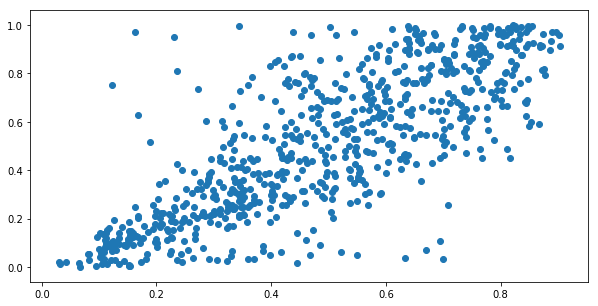

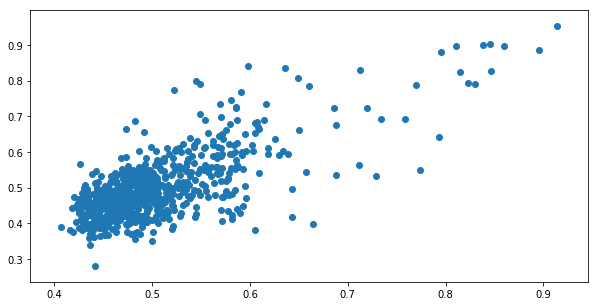

In [9]:
def get_features_targets(df, normsgd=True, drop_0_bin=False, add_features=["shannon"], H1_feature=False, targets=["_lambda"]):
    ## Only use SGD. normalize sgd bins
    X = df.filter(regex="SGD*")
    if normsgd:
        X = X.div(X.sum(axis=1), axis=0)
    if H1_feature:
        X = X.assign(shannon=df["shannon"])
        X["shannon"] = X["shannon"].apply(np.exp)/df["R"]

    if drop_0_bin:
        X = X.drop(["SGD_0"], axis=1)
    if len(add_features) > 0:
        X[add_features] = df[add_features]

    if not len(targets) > 1:
        #y = df.filter(["shannon"]).values.ravel()
        y = df.filter(targets).values.ravel()
    else:
        #y = df.filter(["_lambda", "shannon"])
        y = df.filter(targets)
    return X, y
    
def RF_regress(df, normsgd=True, add_features=[], drop_0_bin=False,\
               H1_feature=True, power_transform=False, pca=False,\
               targets=["_lambda"], cv=True, ax=[]):
    
    X, y = get_features_targets(df, normsgd, drop_0_bin, add_features, H1_feature, targets)
    if "shannon" in targets:
        y = np.exp(y)/df["R"]

    ## Split the data
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

    pt = []
    if power_transform:
        pt = PowerTransformer()
        #pt = StandardScaler()
        #pt = QuantileTransformer()
        Xtrain = pt.fit_transform(Xtrain)
        Xtest = pt.fit_transform(Xtest)
    elif pca:
        pca = PCA(n_components=6)
        Xtrain = pca.fit_transform(Xtrain)
        Xtest = pca.transform(Xtest)
        pt = pca

    model = RandomForestRegressor(n_estimators=800, n_jobs=-1, max_depth=None,\
                                 min_samples_split=5, min_samples_leaf=4, max_features='auto', bootstrap=True)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)

    print(model.feature_importances_)
    print(metrics.explained_variance_score(ypred, ytest))
    print(metrics.r2_score(ypred, ytest))
    
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 5))
        plt.scatter(ypred, ytest)
        
    return pt, model

normsgd = True
drop_0_bin = False
neutral = True
competition = False
filtering = False
if neutral:
    lreg_pt, lregress_model = RF_regress(neut_df, normsgd=normsgd, drop_0_bin=drop_0_bin, targets=["_lambda"], H1_feature=False, power_transform=True, pca=False)#, add_features=["var_local_traits"])
    sreg_pt, sregress_model = RF_regress(neut_df, normsgd=normsgd, drop_0_bin=drop_0_bin, targets=["shannon"], H1_feature=False, power_transform=True, pca=False)#, add_features=["var_local_traits"])
elif False:
    lreg_pt, lregress_model = RF_regress(filt_df, normsgd=normsgd, drop_0_bin=drop_0_bin, targets=["_lambda"], H1_feature=False, power_transform=True, pca=False)#, add_features=["var_local_traits"])
    sreg_pt, sregress_model = RF_regress(filt_df, normsgd=normsgd, drop_0_bin=drop_0_bin, targets=["shannon"], H1_feature=False, power_transform=True, pca=False)#, add_features=["var_local_traits"])
else:
    lreg_pt, lregress_model = RF_regress(comp_df, normsgd=normsgd, drop_0_bin=drop_0_bin, targets=["_lambda"], H1_feature=False, power_transform=True, pca=False)#, add_features=["var_local_traits"])
    sreg_pt, sregress_model = RF_regress(comp_df, normsgd=normsgd, drop_0_bin=drop_0_bin, targets=["shannon"], H1_feature=False, power_transform=True, pca=False)#, add_features=["var_local_traits"])
#    greg_pt, gregress_model = RF_regress(comp_df, normsgd=normsgd, drop_0_bin=drop_0_bin, targets=["generation"], H1_feature=False, power_transform=True, pca=False)#, add_features=["var_local_traits"])
    

In [10]:
X, y = get_features_targets(neut_df)
scores = cross_val_score(regress_model, pt.transform(X), y, cv=10)
scores

NameError: name 'regress_model' is not defined

## RF regression for observed data

In [11]:
for reg_pt, regress_model in zip([lreg_pt, sreg_pt], [lregress_model, sregress_model]):
    for org, dat in obs_dat.items():
        obs = reg_pt.transform([dat])
        pred = regress_model.predict(obs)
        print(org, pred)
    print("Anomura")
    for site, dat in A_dat.items():
        obs = reg_pt.transform([dat])
        pred = regress_model.predict(obs)
        print(site, pred)
    print("Brachyura")
    for site, dat in B_dat.items():
        obs = reg_pt.transform([dat])
        pred = regress_model.predict(obs)
        print(site, pred)
    print("Caridea")
    for site, dat in C_dat.items():
        obs = reg_pt.transform([dat])
        pred = regress_model.predict(obs)
        print(site, pred)
    print("Combined")
    for site, dat in ABC_dat.items():
        obs = reg_pt.transform([dat])
        pred = regress_model.predict(obs)
        print(site, pred)

snails [0.40114589]
moths [0.26976356]
spider [0.25762846]
reunion_weevil [0.12685571]
mauritius_weevil [0.17847066]
Anomura
Pemuteran [0.2680604]
Kalimantan [0.11847579]
Lombok [0.14808797]
Solor [0.25745684]
Lembongan [0.10302962]
RajaAmpat [0.12016289]
Karimunjawa [0.04506929]
BarangLompo [0.11048239]
Manado [0.12235496]
Aceh [0.24585773]
Brachyura
Pemuteran [0.46311746]
Kalimantan [0.27853631]
Lombok [0.1822398]
Solor [0.59917721]
Lembongan [0.09800845]
RajaAmpat [0.46160117]
Karimunjawa [0.09353415]
BarangLompo [0.11059909]
Manado [0.45914727]
Aceh [0.05444124]
Caridea
Pemuteran [0.36859415]
Kalimantan [0.08976077]
Lombok [0.24414255]
Solor [0.2305122]
Lembongan [0.1520202]
RajaAmpat [0.63281023]
Karimunjawa [0.17442566]
BarangLompo [0.15646565]
Manado [0.34745634]
Aceh [0.4400875]
Combined
Pemuteran [0.70945318]
Kalimantan [0.40115145]
Lombok [0.74067751]
Solor [0.8177508]
Lembongan [0.16837311]
RajaAmpat [0.81027884]
Karimunjawa [0.48648183]
BarangLompo [0.25458305]
Manado [0.37

In [848]:
aquatic_regress_dat = {}
for org, dat in aquatic_dat.items():
    obs = reg_pt.transform([dat])
    #print(dat, obs)
    pred = regress_model.predict(obs)
    print(org, pred)
    aquatic_regress_dat[org] = pred[0]

('IV-2012_1.obs', array([0.44247523]))
('II-2015_1.obs', array([0.44689924]))
('IV-2015_1.obs', array([0.45499756]))
('V-2013_4.obs', array([0.46233109]))
('I-2008_7.obs', array([0.45301133]))
('IV-2014_7.obs', array([0.45758787]))
('I-2012_1.obs', array([0.45435914]))
('I-2008_1.obs', array([0.46054259]))
('III-2015_1.obs', array([0.45584548]))
('II-2012_4.obs', array([0.4447602]))
('II-2010_4.obs', array([0.46961674]))
('IV-2012_7.obs', array([0.45590612]))
('III-2011_7.obs', array([0.45512112]))
('I-2011_7.obs', array([0.44900564]))
('I-2009_1.obs', array([0.46597071]))
('V-2009_7.obs', array([0.46110998]))
('V-2010_1_1.obs', array([0.45694004]))
('II-2010_7.obs', array([0.46719924]))
('IV-2007_4.obs', array([0.45520538]))
('V-2007_7.obs', array([0.46249021]))
('V-2011_7.obs', array([0.46726081]))
('III-2007_1.obs', array([0.47052046]))
('III-2009_7.obs', array([0.46574151]))
('II-2012_7.obs', array([0.45754581]))
('II-2011_4.obs', array([0.45686177]))
('I-2014_4.obs', array([0.4582

[0.07754093 0.10118944 0.08485185 0.06539051 0.06238101 0.05725022
 0.05318759 0.04662843 0.05512452 0.39645549]
              precision    recall  f1-score   support

 competition       0.54      0.58      0.56       599
   filtering       0.68      0.57      0.62       867
     neutral       0.80      0.93      0.86       656

   micro avg       0.68      0.68      0.68      2122
   macro avg       0.68      0.69      0.68      2122
weighted avg       0.68      0.68      0.68      2122



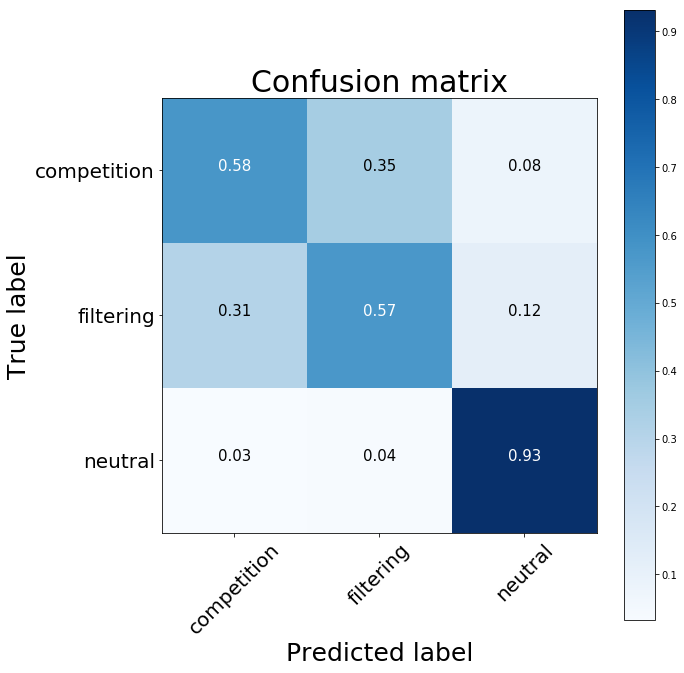

In [12]:
def RF_classify(df, normsgd=True, add_features=[],\
               H1_feature=False, power_transform=False, pca=False,\
                cv=True, ax=[]):
    X, y = get_features_targets(df, normsgd=normsgd, add_features=add_features, H1_feature=H1_feature, targets=["model"])
    ## Split the data
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

    pt = []
    if power_transform:
        pt = PowerTransformer()
        #pt = StandardScaler()
        #pt = QuantileTransformer()
        Xtrain = pt.fit_transform(Xtrain)
        Xtest = pt.fit_transform(Xtest)
    elif pca:
        pca = PCA(n_components=6)
        Xtrain = pca.fit_transform(Xtrain)
        Xtest = pca.transform(Xtest)
        pt = pca

    model = RandomForestClassifier(n_estimators=800, n_jobs=-1, min_samples_split=5, min_samples_leaf=4,\
                                  max_features='auto', max_depth=None, bootstrap=True)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)

    print(model.feature_importances_)
    cm = metrics.confusion_matrix(ypred, ytest)
    print(metrics.classification_report(ypred, ytest))
    plot_confusion_matrix(cm, ["competition", "filtering", "neutral"], normalize=True)
    return pt, model

#cla_pt, classify_model = RF_classify(full_df, normsgd=True, H1_feature=False, power_transform=True, add_features=["var_local_traits"])
cla_pt, classify_model = RF_classify(full_df, H1_feature=False, power_transform=True, normsgd=True)


In [13]:
for org, dat in obs_dat.items():
    obs = cla_pt.transform([dat])
    pred = classify_model.predict(obs)
    pred_proba = classify_model.predict_proba(obs)
    print(org, pred, pred_proba)

ABC_prob_df = {}
print("Anomura")
for site, dat in A_dat.items():
    obs = cla_pt.transform([dat])
    pred = classify_model.predict(obs)
    pred_proba = classify_model.predict_proba(obs)
    print(site, pred, pred_proba)
    ABC_prob_df["Anomura-{}".format(site)] = pred_proba
print("Brachyura")
for site, dat in B_dat.items():
    obs = cla_pt.transform([dat])
    pred = classify_model.predict(obs)
    pred_proba = classify_model.predict_proba(obs)
    print(site, pred, pred_proba)
    ABC_prob_df["Brachyura-{}".format(site)] = pred_proba
print("Caridea")
for site, dat in C_dat.items():
    obs = cla_pt.transform([dat])
    pred = classify_model.predict(obs)
    pred_proba = classify_model.predict_proba(obs)
    print(site, pred, pred_proba)
    ABC_prob_df["Caridea-{}".format(site)] = pred_proba
print("Combined")
for site, dat in ABC_dat.items():
    obs = cla_pt.transform([dat])
    pred = classify_model.predict(obs)
    pred_proba = classify_model.predict_proba(obs)
    print(site, pred, pred_proba)
    ABC_prob_df["Combined-{}".format(site)] = pred_proba


snails ['neutral'] [[0.30077942 0.31122017 0.38800041]]
moths ['neutral'] [[0.01187013 0.0883172  0.89981267]]
spider ['filtering'] [[0.33147982 0.43827518 0.230245  ]]
reunion_weevil ['filtering'] [[0.30642699 0.38502901 0.308544  ]]
mauritius_weevil ['competition'] [[0.47743906 0.34353938 0.17902157]]
Anomura
Pemuteran ['competition'] [[0.45296455 0.42394132 0.12309413]]
Kalimantan ['competition'] [[0.3987495 0.3494937 0.2517568]]
Lombok ['competition'] [[0.38849811 0.37279253 0.23870937]]
Solor ['filtering'] [[0.4139439  0.41933633 0.16671977]]
Lembongan ['competition'] [[0.43834882 0.42843758 0.1332136 ]]
RajaAmpat ['competition'] [[0.54756985 0.29878203 0.15364812]]
Karimunjawa ['filtering'] [[0.37058507 0.37798796 0.25142697]]
BarangLompo ['filtering'] [[0.37172609 0.44610178 0.18217213]]
Manado ['filtering'] [[0.42715947 0.44701497 0.12582555]]
Aceh ['filtering'] [[0.34181614 0.41245438 0.24572948]]
Brachyura
Pemuteran ['filtering'] [[0.28634021 0.36764748 0.34601231]]
Kalimanta

,Anomura-Aceh,Anomura-BarangLompo,Anomura-Kalimantan,Anomura-Karimunjawa,Anomura-Lembongan,Anomura-Lombok,Anomura-Manado,Anomura-Pemuteran,Anomura-RajaAmpat,Anomura-Solor
competition,0.293414,0.355678,0.399652,0.331378,0.434366,0.350132,0.400672,0.446696,0.453084,0.413620
filtering,0.492305,0.448168,0.354414,0.430096,0.425154,0.428189,0.461893,0.436846,0.402072,0.421247
neutral,0.214281,0.196154,0.245934,0.238527,0.140480,0.221679,0.137435,0.116459,0.144845,0.165133


,Brachyura-Aceh,Brachyura-BarangLompo,Brachyura-Kalimantan,Brachyura-Karimunjawa,Brachyura-Lembongan,Brachyura-Lombok,Brachyura-Manado,Brachyura-Pemuteran,Brachyura-RajaAmpat,Brachyura-Solor
competition,0.443895,0.434087,0.470151,0.391364,0.381764,0.581521,0.416663,0.244457,0.476221,0.501127
filtering,0.481127,0.512799,0.465280,0.505870,0.444027,0.321514,0.450824,0.400599,0.443243,0.355265
neutral,0.074978,0.053115,0.064569,0.102766,0.174209,0.096965,0.132513,0.354944,0.080537,0.143608


,Caridea-Aceh,Caridea-BarangLompo,Caridea-Kalimantan,Caridea-Karimunjawa,Caridea-Lembongan,Caridea-Lombok,Caridea-Manado,Caridea-Pemuteran,Caridea-RajaAmpat,Caridea-Solor
competition,0.354467,0.328642,0.458799,0.344591,0.432174,0.526945,0.236770,0.310187,0.370806,0.658329
filtering,0.519184,0.449664,0.381947,0.221809,0.399974,0.369202,0.668397,0.286075,0.417431,0.297856
neutral,0.126349,0.221695,0.159253,0.433599,0.167852,0.103852,0.094833,0.403738,0.211763,0.043816


,Combined-Aceh,Combined-BarangLompo,Combined-Kalimantan,Combined-Karimunjawa,Combined-Lembongan,Combined-Lombok,Combined-Manado,Combined-Pemuteran,Combined-RajaAmpat,Combined-Solor
competition,0.198621,0.298795,0.276490,0.321662,0.116934,0.187292,0.014052,0.319195,0.033616,0.019539
filtering,0.592792,0.556125,0.296686,0.252589,0.340485,0.368672,0.057600,0.366595,0.055700,0.079085
neutral,0.208587,0.145080,0.426824,0.425749,0.542581,0.444035,0.928347,0.314209,0.910683,0.901376


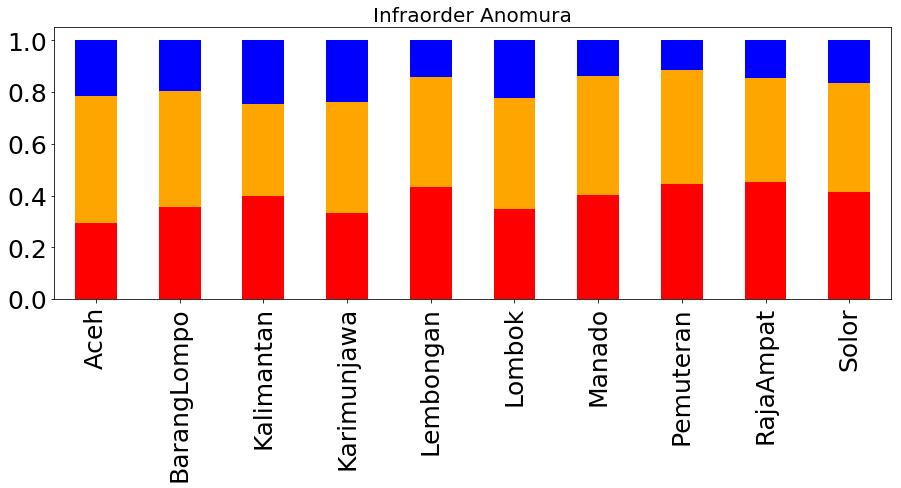

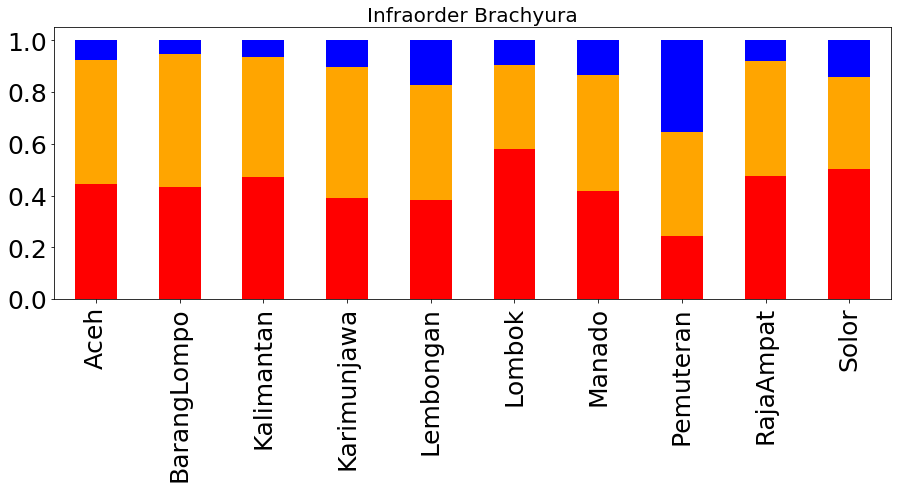

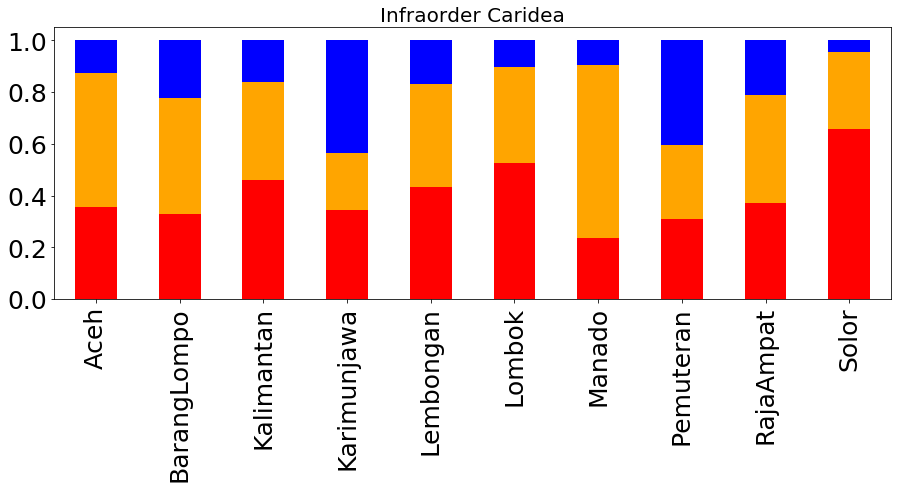

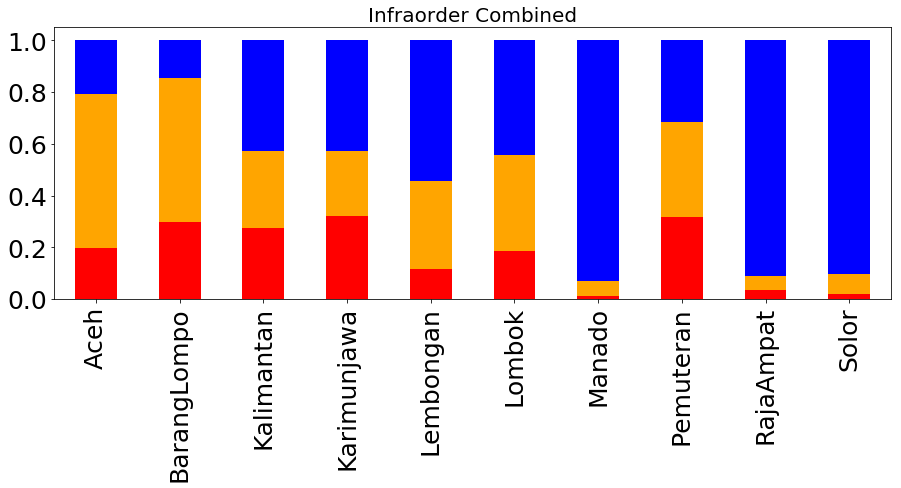

In [954]:
colors = ["red", "orange","blue"]
ABC_proba_df = {site:dat[0] for site, dat in ABC_prob_df.items()}
ABC_proba_df = pd.DataFrame.from_dict(ABC_proba_df, orient="index", columns=["competition", "filtering", "neutral"]).T
#display(ABC_proba_df)
for ABC in ["Anomura", "Brachyura", "Caridea", "Combined"]:
    site = ABC_proba_df.filter(regex="{}-".format(ABC))
    site = site.reindex(sorted(site.columns), axis=1)
    display(site)

    site.columns = [x.split("-")[1] for x in site.columns]
    ax = site.T.loc[:,["competition", "filtering", "neutral"]].plot.bar(stacked=True, color=colors, figsize=(15,5), fontsize=25, legend=False)
    ax.set_title("Infraorder {}".format(ABC), fontsize=20)

## Predict class for each bacterioplankton community per site per timepoint

In [897]:
aq_prob_df = {}
for org, dat in aquatic_dat.items():
    obs = cla_pt.transform([dat])
    pred = classify_model.predict(obs)
    pred_proba = classify_model.predict_proba(obs)
    print(org, pred, pred_proba)
    aq_prob_df[org] = pred_proba

('IV-2012_1.obs', array(['neutral'], dtype=object), array([[0.00696564, 0.09844835, 0.89458601]]))
('II-2015_1.obs', array(['neutral'], dtype=object), array([[0.02490085, 0.02888774, 0.94621141]]))
('IV-2015_1.obs', array(['neutral'], dtype=object), array([[0.004404  , 0.01150979, 0.98408621]]))
('V-2013_4.obs', array(['neutral'], dtype=object), array([[0.01512996, 0.12124855, 0.86362149]]))
('I-2008_7.obs', array(['neutral'], dtype=object), array([[0.0088035 , 0.11295349, 0.87824302]]))
('IV-2014_7.obs', array(['neutral'], dtype=object), array([[0.01647741, 0.01572721, 0.96779538]]))
('I-2012_1.obs', array(['neutral'], dtype=object), array([[0.01146352, 0.10870294, 0.87983354]]))
('I-2008_1.obs', array(['neutral'], dtype=object), array([[0.01424472, 0.10570858, 0.8800467 ]]))
('III-2015_1.obs', array(['neutral'], dtype=object), array([[0.01781934, 0.01943526, 0.96274541]]))
('II-2012_4.obs', array(['neutral'], dtype=object), array([[0.00656052, 0.10229448, 0.891145  ]]))
('II-2010_4.o

('V-2012_1.obs', array(['neutral'], dtype=object), array([[0.02074468, 0.10837727, 0.87087805]]))
('III-2013_7.obs', array(['neutral'], dtype=object), array([[0.02415518, 0.11735868, 0.85848614]]))
('III-2012_1.obs', array(['neutral'], dtype=object), array([[0.00954951, 0.02878296, 0.96166752]]))
('V-2009_1.obs', array(['neutral'], dtype=object), array([[0.0102251 , 0.01751768, 0.97225722]]))
('V-2008_1.obs', array(['neutral'], dtype=object), array([[0.01583297, 0.11163724, 0.87252979]]))
('V-2007_4.obs', array(['neutral'], dtype=object), array([[0.01720743, 0.11119074, 0.87160183]]))
('IV-2010_4.obs', array(['neutral'], dtype=object), array([[0.01125051, 0.03334883, 0.95540066]]))
('I-2015_1.obs', array(['neutral'], dtype=object), array([[0.00257237, 0.00522353, 0.9922041 ]]))
('IV-2008_7.obs', array(['neutral'], dtype=object), array([[0.01741631, 0.11032456, 0.87225914]]))
('III-2008_1.obs', array(['neutral'], dtype=object), array([[0.01364963, 0.1102804 , 0.87606997]]))
('IV-2010_1.

## Bar plots of assignment probabilities per site over time

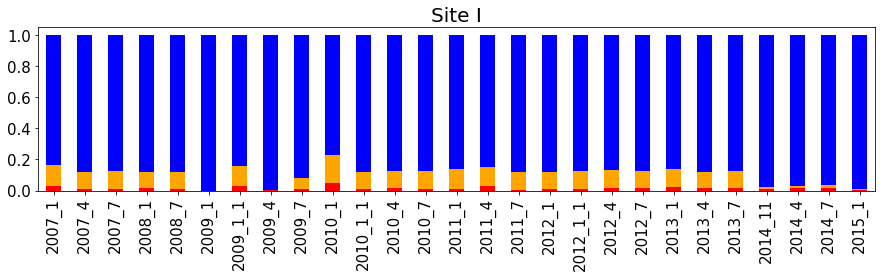

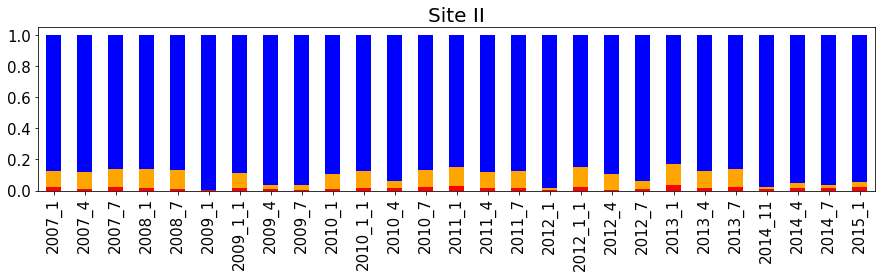

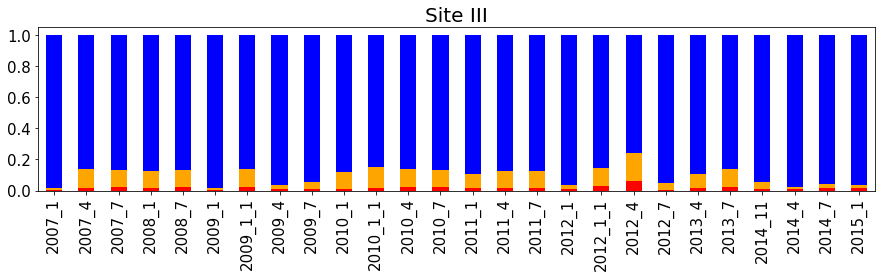

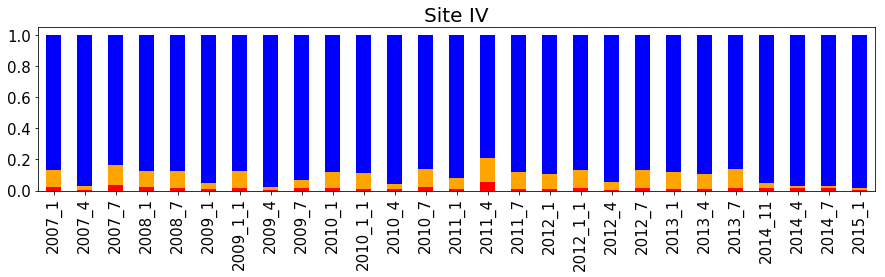

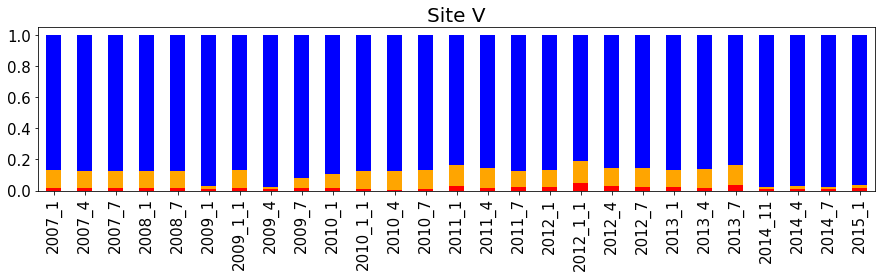

In [941]:
colors = ["red", "orange","blue"]
aq_proba_df = {site:dat[0] for site, dat in aq_prob_df.items()}
aq_proba_df = pd.DataFrame.from_dict(aq_proba_df, orient="index", columns=["competition", "filtering", "neutral"]).T
#display(aq_proba_df)
for siteid in ["I", "II", "III", "IV", "V"]:
    site = aq_proba_df.filter(regex="^{}-.*.obs$".format(siteid))
    site = site.reindex(sorted(site.columns), axis=1)
    site.columns = [x.split(".")[0].split("-")[1] for x in site.columns]
    ax = site.T.loc[:,["competition", "filtering", "neutral"]].plot.bar(stacked=True, color=colors, figsize=(15,3), fontsize=15, legend=False)
    ax.set_title("Site {}".format(siteid), fontsize=20)

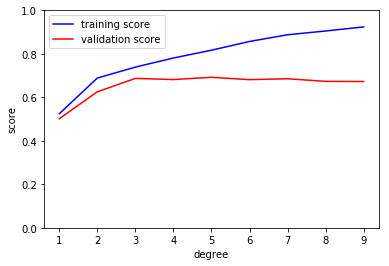

In [515]:
from sklearn.model_selection import validation_curve
degree = np.arange(1, 10)
transform = True
#transform = False
if transform:
    pt = PowerTransformer()
    #pt = StandardScaler()
    #pt = QuantileTransformer()
    Xtrans = pt.fit_transform(X)
train_score, val_score = validation_curve(RandomForestRegressor(), Xtrans, y,
                                          'max_depth', degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

In [531]:
## This is why pipelines are useful
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(), RandomForestRegressor())
pipe.fit(Xtrain, ytrain)
pipe.score(Xtest, ytest)

ValueError: could not convert string to float: filtering

# Parameter tuning

In [584]:

X, y = get_features_targets(full_df, targets=["model"])
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(),\
                               param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2)#, n_jobs = -1)
rf_random.fit(Xtrain, ytrain)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=1800, max_features=auto, min_samples_split=10, max_depth=90 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=1800, max_features=auto, min_samples_split=10, max_depth=90, total=  10.3s
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=1800, max_features=auto, min_samples_split=10, max_depth=90 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s


[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=1800, max_features=auto, min_samples_split=10, max_depth=90, total=  10.0s
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=1800, max_features=auto, min_samples_split=10, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=1800, max_features=auto, min_samples_split=10, max_depth=90, total=   9.8s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=1000, max_features=sqrt, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1000, max_features=sqrt, min_samples_split=10, max_depth=80, total=   5.4s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=1000, max_features=sqrt, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=1000, max_features=sqrt, min_samples_split=10, max_depth=80, total=   5.3s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=1000, max_features=sqrt, min_samples_split=10, max_depth=80 
[CV]  bootstrap=True

[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=400, max_features=sqrt, min_samples_split=2, max_depth=80, total=   3.3s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=400, max_features=sqrt, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=400, max_features=sqrt, min_samples_split=2, max_depth=None, total=   3.3s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=400, max_features=sqrt, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=400, max_features=sqrt, min_samples_split=2, max_depth=None, total=   3.4s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=400, max_features=sqrt, min_samples_split=2, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=400, max_features=sqrt, min_samples_split=2, max_depth=None, total=   3.3s
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=600, max_features=auto, min_samples_split=10, max_depth=30 
[CV]  bootstrap

[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=1400, max_features=auto, min_samples_split=5, max_depth=30, total=  11.1s
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=1400, max_features=auto, min_samples_split=5, max_depth=30 
[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=1400, max_features=auto, min_samples_split=5, max_depth=30, total=  11.1s
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=1400, max_features=auto, min_samples_split=5, max_depth=30 
[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=1400, max_features=auto, min_samples_split=5, max_depth=30, total=  11.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1600, max_features=auto, min_samples_split=10, max_depth=40 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1600, max_features=auto, min_samples_split=10, max_depth=40, total=   8.6s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1600, max_features=auto, min_samples_split=10, max_depth=40 
[CV]  bootstrap=True

[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=800, max_features=sqrt, min_samples_split=10, max_depth=30, total=   5.8s
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=800, max_features=sqrt, min_samples_split=10, max_depth=30 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=800, max_features=sqrt, min_samples_split=10, max_depth=30, total=   5.8s
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=200, max_features=auto, min_samples_split=2, max_depth=20 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=200, max_features=auto, min_samples_split=2, max_depth=20, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=200, max_features=auto, min_samples_split=2, max_depth=20 
[CV]  bootstrap=True, min_samples_leaf=1, n_estimators=200, max_features=auto, min_samples_split=2, max_depth=20, total=   1.2s
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=200, max_features=auto, min_samples_split=2, max_depth=20 
[CV]  bootstrap=True, min_samp

[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=200, max_features=sqrt, min_samples_split=10, max_depth=None, total=   1.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=400, max_features=sqrt, min_samples_split=10, max_depth=50 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=400, max_features=sqrt, min_samples_split=10, max_depth=50, total=   2.0s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=400, max_features=sqrt, min_samples_split=10, max_depth=50 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=400, max_features=sqrt, min_samples_split=10, max_depth=50, total=   2.3s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=400, max_features=sqrt, min_samples_split=10, max_depth=50 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=400, max_features=sqrt, min_samples_split=10, max_depth=50, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=1, n_estimators=2000, max_features=auto, min_samples_split=10, max_depth=100 
[CV]  bootstrap=True, mi

[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=400, max_features=auto, min_samples_split=2, max_depth=60, total=   2.3s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=400, max_features=auto, min_samples_split=2, max_depth=60 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=400, max_features=auto, min_samples_split=2, max_depth=60, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=400, max_features=auto, min_samples_split=2, max_depth=60 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=400, max_features=auto, min_samples_split=2, max_depth=60, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=2000, max_features=sqrt, min_samples_split=2, max_depth=90 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=2000, max_features=sqrt, min_samples_split=2, max_depth=90, total=  11.2s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=2000, max_features=sqrt, min_samples_split=2, max_depth=90 
[CV]  bootstrap=True, min_samples

[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=200, max_features=sqrt, min_samples_split=10, max_depth=None, total=   1.6s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=200, max_features=sqrt, min_samples_split=10, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=200, max_features=sqrt, min_samples_split=10, max_depth=None, total=   1.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=400, max_features=auto, min_samples_split=2, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=400, max_features=auto, min_samples_split=2, max_depth=110, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=400, max_features=auto, min_samples_split=2, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=400, max_features=auto, min_samples_split=2, max_depth=110, total=   2.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=400, max_features=auto, min_samples_split=2, max_depth=110 
[CV]  bootstrap=Tru

[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=400, max_features=auto, min_samples_split=5, max_depth=10, total=   2.6s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1600, max_features=sqrt, min_samples_split=2, max_depth=None 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1600, max_features=sqrt, min_samples_split=2, max_depth=None, total=   8.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1600, max_features=sqrt, min_samples_split=2, max_depth=None 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1600, max_features=sqrt, min_samples_split=2, max_depth=None, total=   8.7s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1600, max_features=sqrt, min_samples_split=2, max_depth=None 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1600, max_features=sqrt, min_samples_split=2, max_depth=None, total=   8.5s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=1200, max_features=auto, min_samples_split=10, max_depth=20 
[CV]  bootstra

[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=400, max_features=sqrt, min_samples_split=5, max_depth=60, total=   3.2s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=400, max_features=sqrt, min_samples_split=5, max_depth=60 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=400, max_features=sqrt, min_samples_split=5, max_depth=60, total=   3.1s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=400, max_features=sqrt, min_samples_split=5, max_depth=60 
[CV]  bootstrap=False, min_samples_leaf=1, n_estimators=400, max_features=sqrt, min_samples_split=5, max_depth=60, total=   3.1s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1800, max_features=auto, min_samples_split=5, max_depth=110 
[CV]  bootstrap=True, min_samples_leaf=4, n_estimators=1800, max_features=auto, min_samples_split=5, max_depth=110, total=   9.5s
[CV] bootstrap=True, min_samples_leaf=4, n_estimators=1800, max_features=auto, min_samples_split=5, max_depth=110 
[CV]  bootstrap=True, min

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 36.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [585]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 800}

In [ ]:
## The most impo
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

classifier = RandomForestClassifier(max_depth=2, n_estimators=100)
classifier.fit(X, y)
print(regr.feature_importances_)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

transform = True
if transform:
    pt = PowerTransformer()
    #pt = StandardScaler()
    #pt = QuantileTransformer()
    Xtrain = pt.fit_transform(Xtrain)
    Xtest = pt.fit_transform(Xtest)

model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=7)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

print(model.feature_importances_)
cm = metrics.confusion_matrix(ypred, ytest)
print(metrics.classification_report(ypred, ytest))
plot_confusion_matrix(cm, ["filtering", "neutral"])


# Crap below here

In [911]:
import glob
aquatic_regress_dat
aquatic_df = pd.DataFrame.from_dict(aquatic_regress_dat, orient="index").T
display(aquatic_df)
for site in ["I", "II", "III", "IV", "V"]:
    site = aquatic_df.filter(regex="^{}-2008".format(site))
    h = sorted(site.columns)
    #print(site[h])
for yr in [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]:
    for mo in [1, 4, 7]:
        site = aquatic_df.filter(regex="^III-{}_{}.obs$".format(yr, mo))
        print(site.values),
    print()

,IV-2012_1.obs,II-2015_1.obs,IV-2015_1.obs,V-2013_4.obs,I-2008_7.obs,IV-2014_7.obs,IV-2009_4.obs,I-2008_1.obs,III-2015_1.obs,II-2012_4.obs,...,I-2014_11.obs,IV-2014_11.obs,V-2014_4.obs,IV-2010_1_1.obs,III-2013_7.obs,IV-2011_1.obs,I-2013_1.obs,IV-2013_7.obs,I-2014_7.obs,I-2012_7.obs
0,0.442475,0.446899,0.454998,0.462331,0.453011,0.457588,0.454498,0.460543,0.455845,0.44476,...,0.448516,0.45678,0.461633,0.452911,0.444115,0.446079,0.436161,0.449765,0.456283,0.452861


[[0.44697102]] [] [[0.47436522]] ()
[[0.45628585]] [[0.44193741]] [[0.46574151]] ()
[[0.45345792]] [[0.45380692]] [[0.46751038]] ()
[[0.44489159]] [[0.45127214]] [[0.45512112]] ()
[[0.45152444]] [[0.44888263]] [[0.45425377]] ()
[] [[0.43964601]] [[0.44411455]] ()
[] [[0.45740211]] [[0.4537343]] ()
[[0.45584548]] [] [] ()


In [688]:
X[["mn_local_traits", "var_local_traits"]] = neut_df[["mn_local_traits", "var_local_traits"]]
X
X.drop(["SGD_0"], axis=1)

,SGD_1,SGD_2,SGD_3,SGD_4,SGD_5,SGD_6,SGD_7,SGD_8,SGD_9,var_local_traits,mn_local_traits
0,0.232143,0.116071,0.089286,0.017857,0.026786,0.017857,0.017857,0.000000,0.008929,24.874761,0.287353
1,0.196721,0.073770,0.049180,0.040984,0.016393,0.000000,0.000000,0.008197,0.008197,11.409320,-0.087190
2,0.196581,0.094017,0.094017,0.034188,0.008547,0.034188,0.017094,0.000000,0.008547,20.606043,2.265735
3,0.184874,0.109244,0.042017,0.008403,0.008403,0.000000,0.008403,0.000000,0.008403,20.587360,-1.257110
4,0.202247,0.146067,0.033708,0.044944,0.022472,0.022472,0.011236,0.011236,0.022472,16.306985,-4.042226
5,0.234848,0.128788,0.037879,0.015152,0.037879,0.037879,0.045455,0.007576,0.007576,19.283144,0.001284
6,0.208333,0.118056,0.048611,0.034722,0.027778,0.006944,0.000000,0.013889,0.006944,19.449519,0.206811
7,0.247619,0.066667,0.019048,0.019048,0.028571,0.000000,0.009524,0.000000,0.009524,26.959500,-3.551698
8,0.221311,0.073770,0.065574,0.024590,0.016393,0.016393,0.000000,0.008197,0.008197,26.833052,-5.289398
9,0.163462,0.057692,0.009615,0.009615,0.000000,0.009615,0.000000,0.009615,0.009615,18.737502,-0.252489
